In [1]:
from mplsoccer import Sbopen
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import streamlit as st
from joblib import load
from db_connection import get_db

In [48]:
db = next(get_db())

In [2]:
event_df = pd.read_csv('../../excel/event_df.csv')
track_df = pd.read_csv('../../excel/track_df.csv')

C:\Users\juras\AppData\Local\Temp\ipykernel_19696\444760366.py:1: DtypeWarning: Columns (43,55,56,58,59,60,61,62,63,65,66,67,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  event_df = pd.read_csv('../../excel/event_df.csv')


In [3]:
event_df = event_df.dropna(subset=['x', 'y'])
event_df = event_df[~event_df[['x', 'y']].isin([float('inf'), float('-inf')]).any(axis=1)]

In [4]:
event_df[event_df[['end_x', 'end_y']].isna().any(axis=1)].type_name.value_counts()

type_name
Ball Receipt         311245
Pressure             103159
Ball Recovery         32876
Duel                  22192
Clearance             13801
Block                 13289
Dribble                9566
Miscontrol             9291
Foul Committed         7942
Dispossessed           7854
Foul Won               7554
Interception           7247
Dribbled Past          5461
Goal Keeper            4805
50/50                  1462
Referee Ball-Drop       822
Shield                  474
Error                   188
Offside                 105
Own Goal For             42
Own Goal Against         42
Name: count, dtype: int64

In [5]:
# if no end => start == end
event_df.loc[event_df['end_x'].isna(), 'end_x'] = event_df['x']
event_df.loc[event_df['end_y'].isna(), 'end_y'] = event_df['y']

In [6]:
event_df = event_df.sort_values(by=['match_id', 'period', 'timestamp'])
event_df_possession_team=event_df[event_df['team_name'] == event_df['possession_team_name']]
# Get first event in each possession
possession_start = event_df_possession_team.groupby(['match_id', 'possession']).first().reset_index()

# Get last event in each possession
possession_end = event_df_possession_team.groupby(['match_id', 'possession']).last().reset_index()



# Merge to have start and end locations
df_possessions = possession_start[['match_id', 'possession', 'team_id', 'team_name', 'x', 'y', 'type_name']].rename(
    columns={'x': 'start_x', 'y': 'start_y', 'type_name': 'start_event'}
).merge(
    possession_end[['match_id', 'possession', 'x', 'y', 'type_name']], 
    on=['match_id', 'possession'], 
    how='left'
).rename(
    columns={'x': 'end_x', 'y': 'end_y', 'type_name': 'end_event'}
)
possession_end.loc[:,['possession_team_name', 'team_name', 'x']]

,possession_team_name,team_name,x
0,Turkey,Turkey,70.4
1,Italy,Italy,96.9
2,Italy,Italy,94.5
3,Italy,Italy,91.6
4,Turkey,Turkey,53.3
...,...,...,...
57931,England Women's,England Women's,108.1
57932,Spain Women's,Spain Women's,107.8
57933,England Women's,England Women's,107.9
57934,Spain Women's,Spain Women's,107.9


In [7]:
# Count occurrences of start and end events
start_event_counts = df_possessions['start_event'].value_counts()
end_event_counts = df_possessions['end_event'].value_counts()

# Print insights
print("Most common possession start events:")
print(start_event_counts)

print("\nMost common possession end events:")
print(end_event_counts)


Most common possession start events:
start_event
Pass                 41923
Ball Recovery         8686
Duel                  2919
Goal Keeper           1683
Interception          1245
Referee Ball-Drop      822
Shot                   518
50/50                   49
Ball Receipt            47
Block                   40
Pressure                 4
Name: count, dtype: int64

Most common possession end events:
end_event
Ball Receipt         18008
Pass                  7913
Shot                  6113
Foul Won              5269
Miscontrol            3588
Dispossessed          3562
Pressure              3363
Dribble               2102
Duel                  1920
Foul Committed        1609
Carry                  984
Goal Keeper            787
Block                  771
Referee Ball-Drop      611
Ball Recovery          456
Clearance              256
50/50                  200
Shield                 157
Interception           102
Offside                 88
Own Goal For            38
Dribbled Past  

# 🏟️ Step 1: Define Pitch Zones


In [8]:
print(event_df['x'].min(),event_df['x'].max())
print(event_df['y'].min(),event_df['y'].max())

0.1 120.5
0.1 80.0


In [9]:
def get_pitch_zone(x, y):
    # Define horizontal zones (x-axis)
    if x < 40:
        horiz_zone = 'Defensive'
    elif x <= 80:
        horiz_zone = 'Middle'
    else:
        horiz_zone = 'Attacking'

    # Define vertical zones (y-axis)
    if y < 20:
        vert_zone = 'Right'
    elif y <= 60:
        vert_zone = 'Center'
    else:
        vert_zone = 'Left'
    
    return f"{horiz_zone} {vert_zone}"

# Apply function to create start and end zones
event_df['start_zone'] = event_df.apply(lambda row: get_pitch_zone(row['x'], row['y']), axis=1)
event_df['end_zone'] = event_df.apply(lambda row: get_pitch_zone(row['end_x'], row['end_y']), axis=1)


In [10]:
df_event = event_df

# 🏃‍♂️ Step 2: Compute Movement Features

In [11]:
df_event['distance'] = np.sqrt((df_event['x'] - df_event['end_x']) ** 2 + (df_event['y'] - df_event['end_y']) ** 2)
df_event['progression'] = df_event['end_x'] - df_event['x']
df_event['directness'] = np.where(df_event['distance'] != 0, df_event['progression'] / df_event['distance'], 0)
df_event['width_change'] = abs(df_event['end_y'] - df_event['y'])
df_event['speed'] = np.where(df_event['duration'] != 0, df_event['distance'] / df_event['duration'], 0)
df_event['distance_covered'] = np.sqrt((df_event['end_x'] - df_event['x']) ** 2 + (df_event['end_y'] - df_event['y']) ** 2)
df_event['angle_change'] = np.arctan2(df_event['end_y'] - df_event['y'], df_event['end_x'] - df_event['x'])

Packing Metrics

In [12]:
id_pos = event_df.loc[:,['id', 'x', 'y', 'end_x', 'end_y']]
id_pos = id_pos.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
track_df_full = track_df.merge(id_pos, on='id', how='left')
track_df_full = track_df_full[track_df_full['actor']==False]
track_df_full['distance'] = np.sqrt((track_df_full['x'] - track_df_full['ball_x'])**2 + (track_df_full['y'] - track_df_full['ball_y'])**2)

track_df_full['packing'] = (track_df_full['x'] > track_df_full['ball_x']) & (track_df_full['x'] < track_df_full['end_x'])
teammates_df = track_df_full[track_df_full['teammate'] == True]
teammates_df = teammates_df.rename(columns={'distance': 'teammate_distance'})
opponents_df = track_df_full[track_df_full['teammate'] == False]
opponents_df = opponents_df.rename(columns={'distance': 'opponent_distance'})
track_df_full['nearby_opponents'] = (track_df_full['distance'] < 10) & (track_df_full['teammate']==False)
track_df_full['nearby_teammates'] = (track_df_full['distance'] < 10) & (track_df_full['teammate']==True)


teammate_distance_min = teammates_df.groupby(['id'])['teammate_distance'].min().reset_index()
opponent_distance_min = opponents_df.groupby('id')['opponent_distance'].min().reset_index()
distance_count = track_df_full.groupby('id')['nearby_opponents'].sum().reset_index()
distance_count_teammates = track_df_full.groupby('id')['nearby_teammates'].sum().reset_index()
packing = opponents_df.groupby('id')['packing'].sum().reset_index()
#packing_metric = 


df_event = df_event.merge(distance_count, on='id', how='left')
df_event = df_event.merge(distance_count_teammates, on='id', how='left')
df_event = df_event.merge(teammate_distance_min, on='id', how='left')
df_event = df_event.merge(opponent_distance_min, on='id', how='left')
df_event = df_event.merge(packing, on='id', how='left')

In [13]:
def calculate_packing_metric2(event, track_df, threshold=3):
    event_id = event["id"]
    start_x, start_y, end_x, end_y = event["x"], event["y"], event["end_x"], event["end_y"]
    
    # Retrieve opponent positions for the given event
    opponents = track_df.loc[(track_df["id"] == event_id) & (track_df["teammate"] == False), ["x", "y"]]

    if opponents.empty:
        return 0  # No opponents present
    
    # Vectorized point-to-line distance calculation
    dx = end_x - start_x
    dy = end_y - start_y
    line_length_sq = dx**2 + dy**2

    if line_length_sq == 0:
        return 0  # No movement, no packing

    # Projection factor t for each opponent
    t = ((opponents["x"] - start_x) * dx + (opponents["y"] - start_y) * dy) / line_length_sq
    t = np.clip(t, 0, 1)  # Ensure projections are within segment

    # Closest points on the action path
    closest_x = start_x + t * dx
    closest_y = start_y + t * dy

    # Euclidean distances from opponents to action path
    distances = np.sqrt((opponents["x"] - closest_x)**2 + (opponents["y"] - closest_y)**2)

    # Count opponents within the threshold distance
    return np.sum(distances < threshold)

#df_event["packing_metric"] = df_event.apply(calculate_packing_metric2, track_df=track_df, threshold=3, axis=1)

In [14]:
df_event.foul_won_defensive.value_counts()    

foul_won_defensive
True    2205
Name: count, dtype: int64

# 📊 Possession level aggregation


In [15]:
df_pressure = df_event.groupby(['match_id', 'possession'])['under_pressure'].sum().reset_index()
df_pressure.rename(columns={'under_pressure': 'pressure_count'}, inplace=True)

# Count event types 
df_counts = df_event.groupby(['match_id', 'possession'])['type_name'].value_counts().unstack(fill_value=0).reset_index()
df_counts = df_counts[['match_id', 'possession', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel', 'Pressure', 'Block', 'Ball Recovery', 'Interception', 'Clearance']].fillna(0)

df_pass = df_event[(df_event['type_name'] == 'Pass') & (df_event['team_name'] == df_event['possession_team_name'])].groupby(['match_id', 'possession']).agg(
    all_passes = ('pass_length', 'count'),
    successful_passes = ('outcome_name', lambda x: (x.isin([np.nan, 'Complete', 'Success', 'Success In Play', 'Success To Team'])).sum()),
    avg_pass_length = ('pass_length', 'mean'),
    avg_pass_angle = ('pass_angle', 'mean'),
    longest_forward_pass = ('progression', 'max')
).reset_index()
df_pass['pass_success_rate'] = df_pass['successful_passes'] / df_pass['all_passes']
df_pass.fillna(0, inplace=True)

# Merge pass-related features into df_counts
df_counts = df_counts.merge(df_pass[['match_id', 'possession', 'successful_passes','all_passes', 'avg_pass_length', 'avg_pass_angle', 'pass_success_rate', 'longest_forward_pass']], 
                            on=['match_id', 'possession'], how='left')

# Aggregate movement features
df_movement = df_event.groupby(['match_id', 'possession']).agg(
    total_distance=('distance', 'sum'),
    avg_progression=('progression', 'mean'),
    avg_directness=('directness', 'mean'),
    total_width_change=('width_change', 'sum'),
    avg_speed=('speed', 'mean')
).reset_index()


df_pass_types = df_event[df_event['type_name'] == 'Pass'].groupby(['match_id', 'possession'])['pass_height_name'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pass_types.columns = ['match_id', 'possession'] + [f'{col.lower().replace(" ", "_")}' for col in df_pass_types.columns[2:]]

# Aggregate pitch zone counts (start zones)
df_pitch_zones = df_event.groupby(['match_id', 'possession'])['start_zone'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pitch_zones.columns = ['match_id', 'possession'] + [f'start_{col.lower().replace(" ", "_")}' for col in df_pitch_zones.columns[2:]]

# Aggregate pitch zone counts (end zones)
df_pitch_zones_end = df_event.groupby(['match_id', 'possession'])['end_zone'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pitch_zones_end.columns = ['match_id', 'possession'] + [f'end_{col.lower().replace(" ", "_")}' for col in df_pitch_zones_end.columns[2:]]


# Attacking effectiveness
df_attacking = df_event.groupby(['match_id', 'possession']).agg(total_xg=('shot_statsbomb_xg', 'sum')).reset_index()

# Pressure & support
df_pressure_support = df_event.groupby(['match_id', 'possession']).agg(
    avg_opponent_distance=('opponent_distance', 'mean'),
    avg_teammate_distance=('teammate_distance', 'mean'),
    avg_opponent_count=('nearby_opponents', 'mean'),
    avg_teammate_count=('nearby_teammates', 'mean')).reset_index()


# Packing sum
df_packing = df_event.groupby(['match_id', 'possession']).agg(
    total_packing=('packing', 'sum')).reset_index()



df_fouls_won = df_event.groupby(['match_id', 'possession']).agg(
    foul_won_penalty=('foul_won_penalty', 'sum'),
    foul_won_defensive=('foul_won_defensive', 'sum')
).reset_index()
df_fouls_won['foul_won_total'] = df_fouls_won[['foul_won_defensive', 'foul_won_penalty']].sum(axis=1)

df_fouls_committed = df_event.groupby(['match_id', 'possession']).agg(
    foul_committed_offensive=('foul_committed_offensive', 'sum'),
    foul_committed_penalty=('foul_committed_penalty', 'sum'),
    foul_committed_card=('foul_committed_card_id', 'sum'),

).reset_index()
df_fouls_committed['foul_committed_total'] = df_fouls_committed[['foul_committed_offensive', 'foul_committed_penalty']].sum(axis=1)

df_counterpress = df_event.groupby(['match_id', 'possession'])['counterpress'].sum().reset_index()
df_counterpress.rename(columns={'counterpress': 'counterpress_count'}, inplace=True)
df_pass_switch = df_event.groupby(['match_id', 'possession'])['pass_switch'].sum().reset_index()
df_pass_cut_back = df_event.groupby(['match_id', 'possession'])['pass_cut_back'].sum().reset_index()


df_aerial_duels = df_event.groupby(['match_id', 'possession'])['aerial_won'].sum().reset_index()
df_aerial_duels.rename(columns={'aerial_won': 'aerial_duels_won'}, inplace=True)
df_duration = df_event.groupby(['match_id', 'possession']).agg(avg_duration=('duration', 'mean')).reset_index()

df_play_pattern = df_event.groupby(['match_id', 'possession'])['play_pattern_name'].first().reset_index()
df_play_pattern.rename(columns={'play_pattern_name': 'play_pattern'}, inplace=True)

df_possession_start_end = df_possessions.loc[:,['match_id', 'possession', 'start_x','start_y', 'end_x', 'end_y']]



# Merge all aggregated data into a possession-level DataFrame
possession_features = df_counts \
    .merge(df_pressure, on=['match_id', 'possession'], how='left') \
    .merge(df_movement, on=['match_id', 'possession'], how='left') \
    .merge(df_pass_types, on=['match_id', 'possession'], how='left') \
    .merge(df_pitch_zones, on=['match_id', 'possession'], how='left') \
    .merge(df_pitch_zones_end, on=['match_id', 'possession'], how='left') \
    .merge(df_attacking, on=['match_id', 'possession'], how='left') \
    .merge(df_fouls_won[['match_id', 'possession', 'foul_won_total']], on=['match_id', 'possession'], how='left') \
    .merge(df_fouls_committed[['match_id', 'possession', 'foul_committed_total']], on=['match_id', 'possession'], how='left') \
    .merge(df_possession_start_end, on=['match_id', 'possession'], how='left') \
    .merge(df_counterpress[['match_id', 'possession', 'counterpress_count']], on=['match_id', 'possession'], how='left') \
    .merge(df_pass_switch[['match_id', 'possession', 'pass_switch']], on=['match_id', 'possession'], how='left') \
    .merge(df_pass_cut_back[['match_id', 'possession', 'pass_cut_back']], on=['match_id', 'possession'], how='left') \
    .merge(df_aerial_duels[['match_id', 'possession', 'aerial_duels_won']], on=['match_id', 'possession'], how='left') \
    .merge(df_duration[['match_id', 'possession', 'avg_duration']], on=['match_id', 'possession'], how='left') \
    .merge(df_play_pattern[['match_id', 'possession', 'play_pattern']], on=['match_id', 'possession'], how='left') \
    .merge(df_pressure_support, on=['match_id', 'possession'], how='left') \
    .merge(df_packing, on=['match_id', 'possession'], how='left')

# Fill NaN values with 0 where needed
possession_features.fillna(0, inplace=True)
possession_features_original = possession_features.copy()


In [16]:
columns_to_convert = ['foul_won_total', 'foul_committed_total', 'pass_switch', 'pass_cut_back', 'aerial_duels_won']

for col in columns_to_convert:
    possession_features[col] = possession_features[col].replace({True: 1, False: 0}).astype(float)

C:\Users\juras\AppData\Local\Temp\ipykernel_19696\1062955469.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  possession_features[col] = possession_features[col].replace({True: 1, False: 0}).astype(float)
C:\Users\juras\AppData\Local\Temp\ipykernel_19696\1062955469.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  possession_features[col] = possession_features[col].replace({True: 1, False: 0}).astype(float)
C:\Users\juras\AppData\Local\Temp\ipykernel_19696\1062955469.py:4: FutureWarning: Downcasting behavior in `replace` is d

In [17]:
possession_features.describe()['start_middle_center']

count    57936.000000
mean         0.171717
std          0.223256
min          0.000000
25%          0.000000
50%          0.076923
75%          0.285714
max          1.000000
Name: start_middle_center, dtype: float64

In [18]:
possession_features.columns

Index(['match_id', 'possession', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel',
       'Pressure', 'Block', 'Ball Recovery', 'Interception', 'Clearance',
       'successful_passes', 'all_passes', 'avg_pass_length', 'avg_pass_angle',
       'pass_success_rate', 'longest_forward_pass', 'pressure_count',
       'total_distance', 'avg_progression', 'avg_directness',
       'total_width_change', 'avg_speed', 'ground_pass', 'high_pass',
       'low_pass', 'start_attacking_center', 'start_attacking_left',
       'start_attacking_right', 'start_defensive_center',
       'start_defensive_left', 'start_defensive_right', 'start_middle_center',
       'start_middle_left', 'start_middle_right', 'end_attacking_center',
       'end_attacking_left', 'end_attacking_right', 'end_defensive_center',
       'end_defensive_left', 'end_defensive_right', 'end_middle_center',
       'end_middle_left', 'end_middle_right', 'total_xg', 'foul_won_total',
       'foul_committed_total', 'start_x', 'start_y', 'end_x', '

In [19]:
possession_features.to_excel('../../excel/possession_features.xlsx', index=False)

In [20]:
possession_features = pd.read_excel('../../excel/possession_features.xlsx')

In [21]:
possession_features.columns 

Index(['match_id', 'possession', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel',
       'Pressure', 'Block', 'Ball Recovery', 'Interception', 'Clearance',
       'successful_passes', 'all_passes', 'avg_pass_length', 'avg_pass_angle',
       'pass_success_rate', 'longest_forward_pass', 'pressure_count',
       'total_distance', 'avg_progression', 'avg_directness',
       'total_width_change', 'avg_speed', 'ground_pass', 'high_pass',
       'low_pass', 'start_attacking_center', 'start_attacking_left',
       'start_attacking_right', 'start_defensive_center',
       'start_defensive_left', 'start_defensive_right', 'start_middle_center',
       'start_middle_left', 'start_middle_right', 'end_attacking_center',
       'end_attacking_left', 'end_attacking_right', 'end_defensive_center',
       'end_defensive_left', 'end_defensive_right', 'end_middle_center',
       'end_middle_left', 'end_middle_right', 'total_xg', 'foul_won_total',
       'foul_committed_total', 'start_x', 'start_y', 'end_x', '

In [22]:
import pandas as pd
# Wide Focus = Width-related features (Summing all start & end width-related positions)
possession_features["wide_focus"] = (
    possession_features["start_attacking_left"] +
    possession_features["start_attacking_right"] +
    possession_features["start_middle_left"] +
    possession_features["start_middle_right"] +
    possession_features["start_defensive_left"] +
    possession_features["start_defensive_right"] +
    possession_features["end_attacking_left"] +
    possession_features["end_attacking_right"] +
    possession_features["end_middle_left"] +
    possession_features["end_middle_right"] +
    possession_features["end_defensive_left"] +
    possession_features["end_defensive_right"]
)

possession_features["defensive_start"] = (
    possession_features["start_defensive_left"] +
    possession_features["start_defensive_right"] +
    possession_features["start_defensive_center"]
)
possession_features["middle_start"] = (
    possession_features["start_middle_left"] +
    possession_features["start_middle_right"] +
    possession_features["start_middle_center"]
)
possession_features["attacking_start"] = (
    possession_features["start_attacking_left"] +
    possession_features["start_attacking_right"] +
    possession_features["start_attacking_center"]
)

# Defensive Intensity = Clearance + Interception + Block + Duel + Pressure
possession_features["defensive_intensity"] = (
    possession_features["Clearance"] +
    possession_features["Interception"] +
    possession_features["Block"] +
    possession_features["Duel"] +
    possession_features["Pressure"]
)

# Foul Intensity = Total fouls won & committed
possession_features["foul_intensity"] = (
    possession_features["foul_won_total"] + possession_features["foul_committed_total"]
)

# On-the-Ball Actions = Pass + Dribble + Carry
possession_features["on_ball_actions"] = (
    possession_features["Pass"] + possession_features["Dribble"] + possession_features["Carry"]
)

# Dropping original columns to avoid redundancy
features_to_drop = [
    # Wide Focus Components
    "start_attacking_left", "start_attacking_right", "start_middle_left", "start_middle_right",
    "start_defensive_left", "start_defensive_right", "end_attacking_left", "end_attacking_right",
    "end_middle_left", "end_middle_right", "end_defensive_left", "end_defensive_right",
    "end_attacking_center", "end_defensive_center", "end_middle_center",
    "start_attacking_center", "start_defensive_center", "start_middle_center",
    # Defensive Intensity
    "Clearance", "Interception", "Block", "Duel", "Pressure",
    # Foul Intensity
    "foul_won_total", "foul_committed_total",
    # On-the-Ball Actions
    "Pass", "Dribble", "Carry",
    # Defensive Actions
    "Ball Recovery",
    # Highly Correlated Features
    "ground_pass","total_width_change", "successful_passes", "pressure_count","all_passes", "total_distance",
    #"total_width_change", "total_packing", "total_duration", "wide_focus", "defensive_intensity", "on_ball_actions", "defensive_actions"
     'avg_directness','low_pass', 'Shot',
       'pass_switch', 'pass_cut_back', 'aerial_duels_won', 'defensive_start', 'middle_start'
]

possession_features.drop(columns=features_to_drop, inplace=True)


In [23]:
possession_features.columns

Index(['match_id', 'possession', 'avg_pass_length', 'avg_pass_angle',
       'pass_success_rate', 'longest_forward_pass', 'avg_progression',
       'avg_speed', 'high_pass', 'total_xg', 'start_x', 'start_y', 'end_x',
       'end_y', 'counterpress_count', 'avg_duration', 'play_pattern',
       'avg_opponent_distance', 'avg_teammate_distance', 'avg_opponent_count',
       'avg_teammate_count', 'total_packing', 'wide_focus', 'attacking_start',
       'defensive_intensity', 'foul_intensity', 'on_ball_actions'],
      dtype='object')

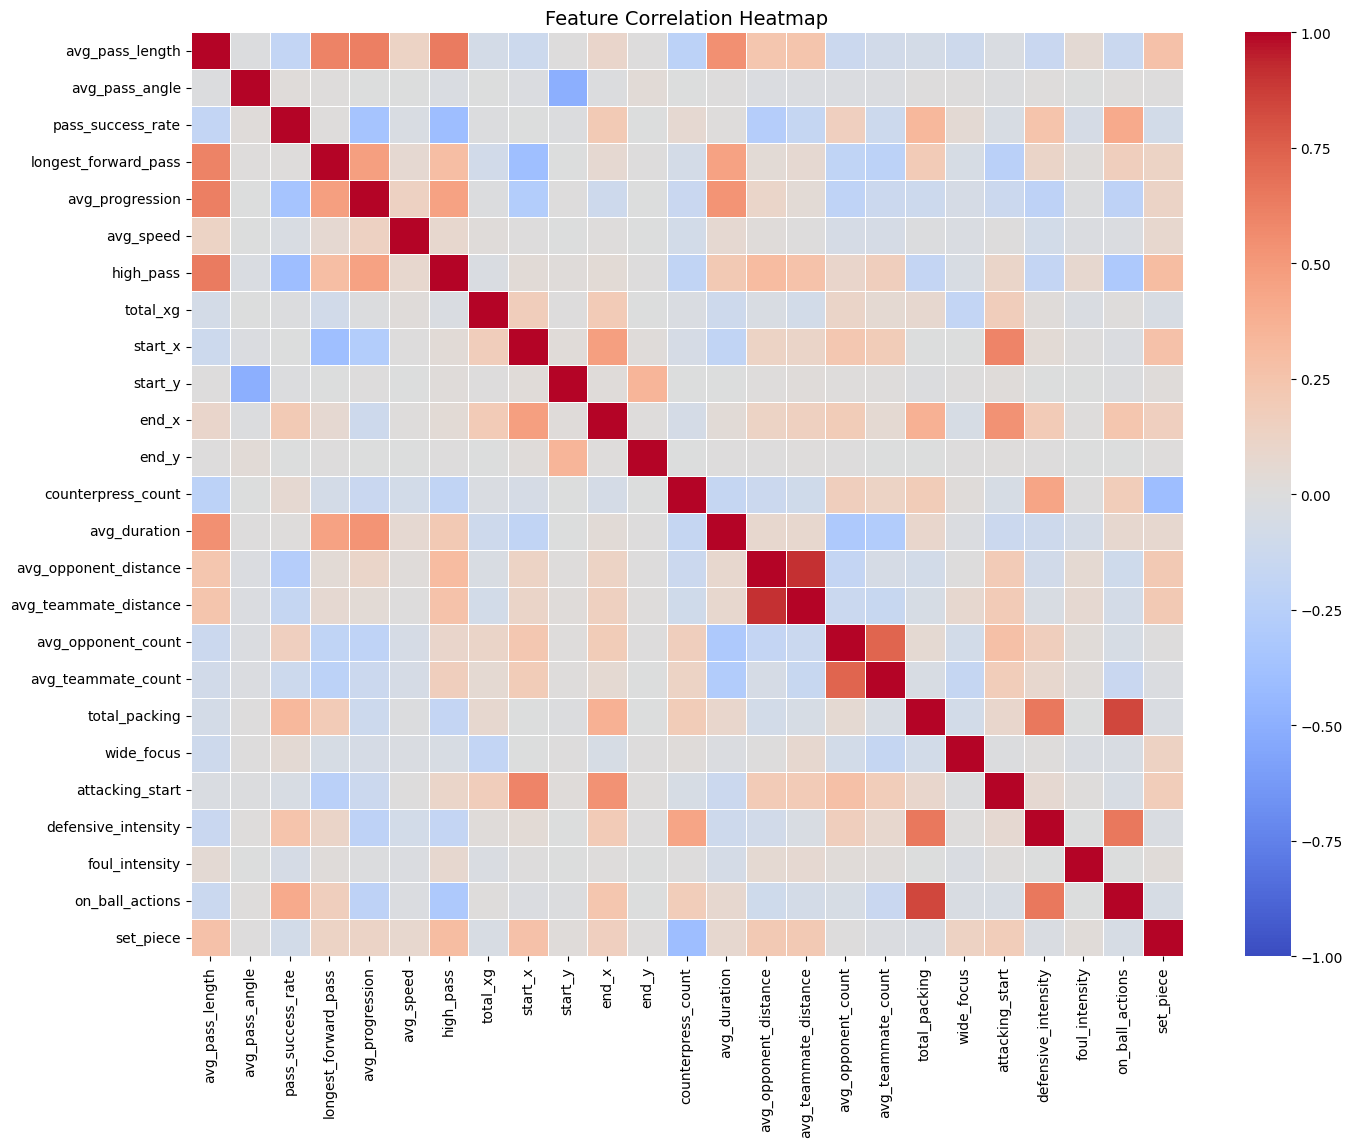

Highly correlated feature pairs (correlation > 0.80):
avg_teammate_distance and avg_opponent_distance: 0.91
on_ball_actions and total_packing: 0.84


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

non_numeric_cols = ['match_id', 'possession', 'play_pattern', 'style', 'style1']

df_play_pattern = pd.get_dummies(possession_features, columns=['play_pattern'])
possession_features['set_piece'] = possession_features['play_pattern'].isin([
    'From Corner', 'From Goal Kick', 'From Free Kick', 'From Kick Off', 'From Throw In'
])

df_numeric = possession_features.drop(columns=non_numeric_cols, errors='ignore')
corr_matrix = df_numeric.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

corr_matrix = df_numeric.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, row, upper_triangle.loc[row, col])
    for col in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, col] > 0.80
]

if high_corr_pairs:
    print("Highly correlated feature pairs (correlation > 0.80):")
    for col1, col2, corr_value in high_corr_pairs:
        print(f"{col1} and {col2}: {corr_value:.2f}")
else:
    print("No feature pairs with correlation greater than 0.80.")


In [25]:
possession_features["possession_dynamics"] = (
    possession_features["avg_progression"] +
    possession_features["avg_speed"] +
    possession_features["high_pass"]
) / 3

possession_features["defensive_aggression"] = (
    possession_features["defensive_intensity"] + possession_features["foul_intensity"]
) / 2

features_to_drop = [
    "avg_progression", "avg_speed", "high_pass", "defensive_intensity",
    "foul_intensity"
]

possession_features.drop(columns=features_to_drop, inplace=True)

In [26]:
df_numeric.columns  

Index(['avg_pass_length', 'avg_pass_angle', 'pass_success_rate',
       'longest_forward_pass', 'avg_progression', 'avg_speed', 'high_pass',
       'total_xg', 'start_x', 'start_y', 'end_x', 'end_y',
       'counterpress_count', 'avg_duration', 'avg_opponent_distance',
       'avg_teammate_distance', 'avg_opponent_count', 'avg_teammate_count',
       'total_packing', 'wide_focus', 'attacking_start', 'defensive_intensity',
       'foul_intensity', 'on_ball_actions', 'set_piece'],
      dtype='object')

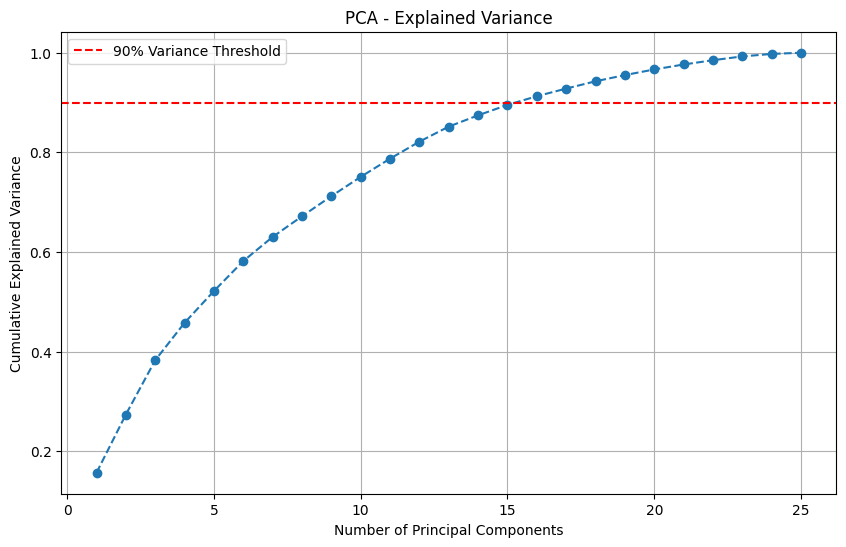

Optimal number of components: 16
PCA Feature Loadings:
                            PC1       PC2       PC3       PC4       PC5  \
avg_pass_length        0.379836 -0.059570  0.213512  0.231789 -0.015246   
avg_pass_angle        -0.006353 -0.037326 -0.013499 -0.031877 -0.579379   
pass_success_rate     -0.243232 -0.178522  0.130021 -0.055666 -0.018370   
longest_forward_pass   0.241369 -0.303133  0.224356  0.190475  0.002285   
avg_progression        0.364615 -0.127692  0.040985  0.244442 -0.001948   
avg_speed              0.084935 -0.009513  0.032693  0.048103 -0.026704   
high_pass              0.326660  0.163867  0.126437  0.261859 -0.007021   
total_xg              -0.074782  0.116642  0.067465  0.129947 -0.036623   
start_x               -0.119011  0.392751  0.193812 -0.067359 -0.039481   
start_y                0.007458  0.040352  0.019715  0.022659  0.711103   
end_x                 -0.088000  0.171546  0.420010  0.030038 -0.036436   
end_y                  0.002502  0.017420  0.

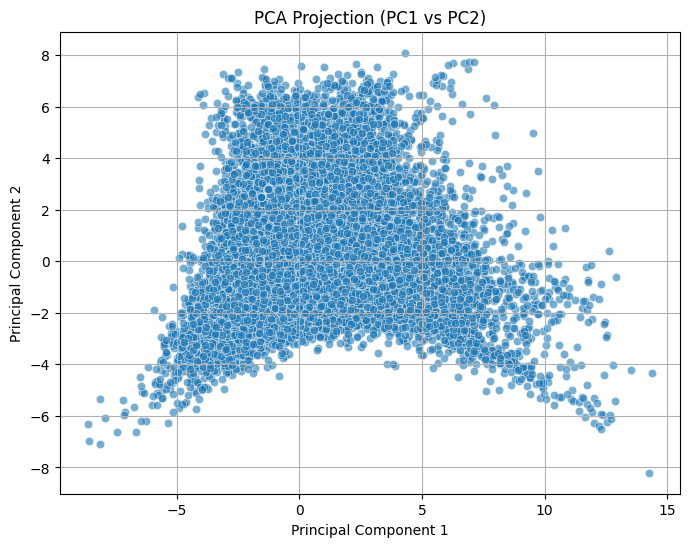

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

# 2️⃣ Apply PCA
pca = PCA()
pca.fit(scaled_features)

# 3️⃣ Plot Explained Variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid()
plt.legend()
plt.show()

# 4️⃣ Determine the Optimal Number of Components
n_components = np.argmax(explained_variance >= 0.90) + 1  # Selecting components explaining ≥90% variance
print(f"Optimal number of components: {n_components}")

# 5️⃣ Transform Data Using PCA
pca_final = PCA(n_components=n_components)
pca_features = pca_final.fit_transform(scaled_features)

# 6️⃣ Create DataFrame with PCA components
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(n_components)])

# 7️⃣ Analyze Feature Loadings (Contribution of each feature to principal components)
loadings = pd.DataFrame(pca_final.components_.T, index=df_numeric.columns, columns=[f'PC{i+1}' for i in range(n_components)])
print("PCA Feature Loadings:")
print(loadings)

# 8️⃣ Visualize the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (PC1 vs PC2)')
plt.grid()
plt.show()


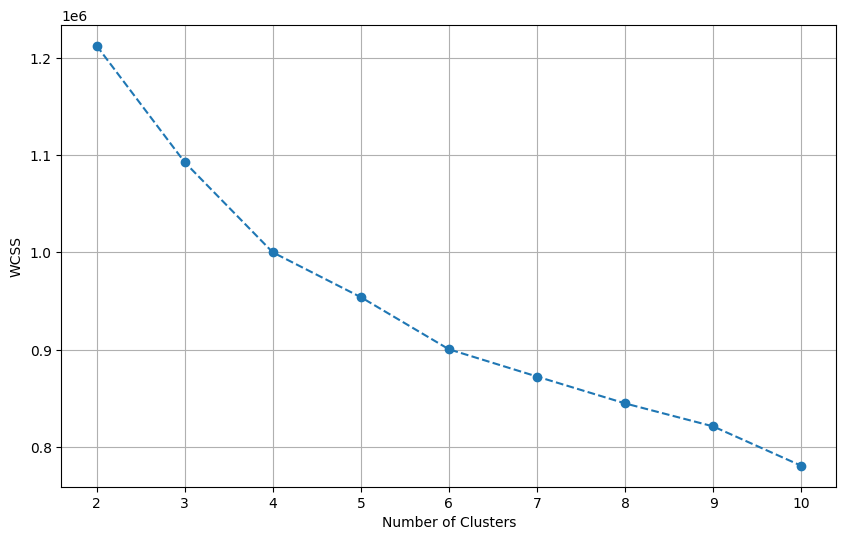

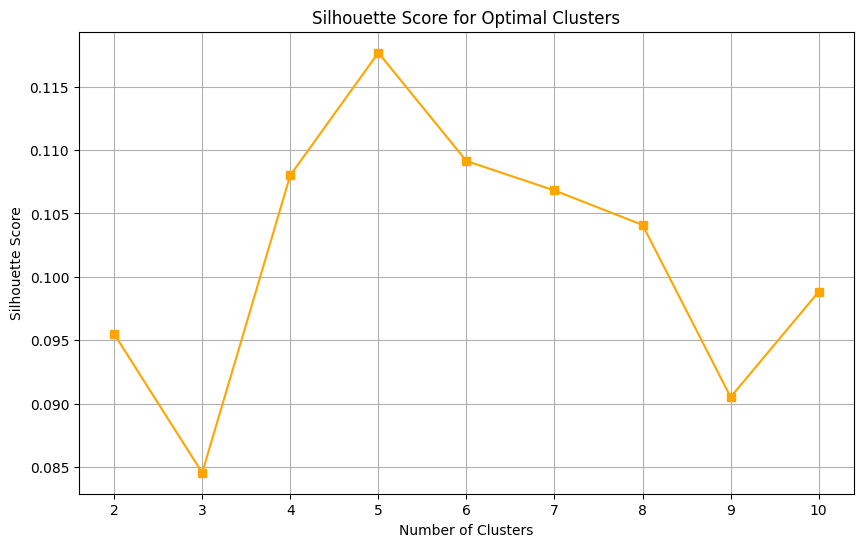

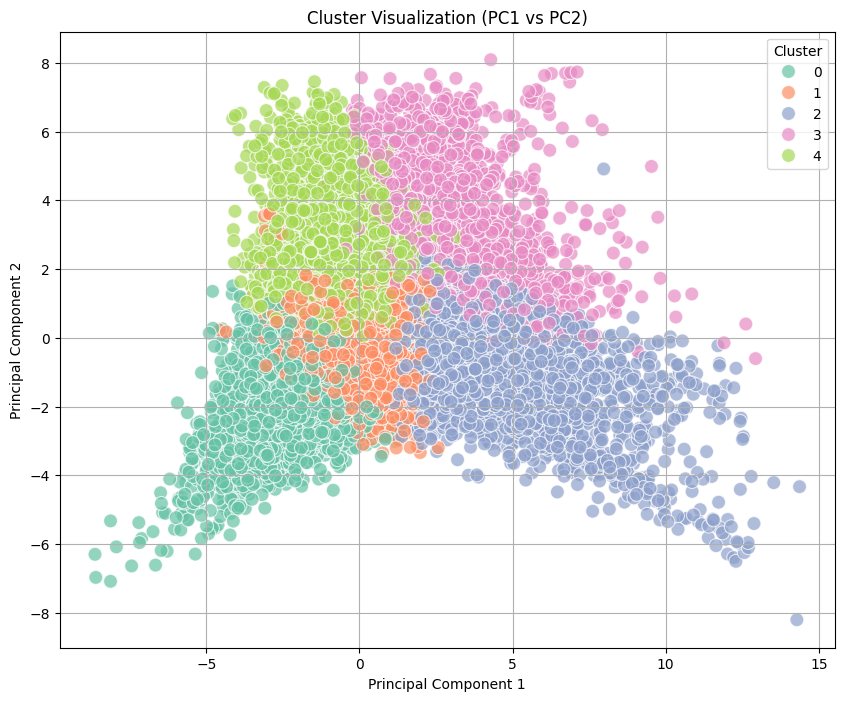

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares

for i in range(2, 11):  # Testing between 2 and 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

# 2️⃣ Silhouette Score to support the elbow method
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='s', linestyle='-', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.grid()
plt.show()

# 3️⃣ Apply K-Means with the optimal number of clusters (let's assume 4 based on elbow/silhouette)
optimal_clusters = 5  # Adjust this based on your elbow/silhouette plot results
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)

# Predict clusters
pca_df['Cluster'] = kmeans_final.fit_predict(pca_df)


# 4️⃣ Visualize Clusters in PCA Space
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Cluster'], palette='Set2', s=100, alpha=0.7)
plt.title('Cluster Visualization (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# 5️⃣ Analyze the average feature values per cluster (to profile playing styles)
cluster_profiles = pd.concat([pca_df, df_numeric.reset_index(drop=True)], axis=1)
cluster_summary = cluster_profiles.groupby('Cluster').mean()


In [29]:
possession_features["Cluster"] = pca_df['Cluster']
possession_features.columns

Index(['match_id', 'possession', 'avg_pass_length', 'avg_pass_angle',
       'pass_success_rate', 'longest_forward_pass', 'total_xg', 'start_x',
       'start_y', 'end_x', 'end_y', 'counterpress_count', 'avg_duration',
       'play_pattern', 'avg_opponent_distance', 'avg_teammate_distance',
       'avg_opponent_count', 'avg_teammate_count', 'total_packing',
       'wide_focus', 'attacking_start', 'on_ball_actions', 'set_piece',
       'possession_dynamics', 'defensive_aggression', 'Cluster'],
      dtype='object')

In [30]:
a = possession_features.loc[:,["Cluster", 'avg_pass_length', 'wide_focus', 'attacking_start','total_xg']].groupby(["Cluster"]).describe().T
a

Cluster                           0             1            2            3  \
avg_pass_length count  12303.000000  25818.000000  6277.000000  2716.000000   
                mean      19.791636     17.768692    47.065089    31.335679   
                std        4.377993      8.987649    16.757526    14.295877   
                min        0.000000      0.000000     0.000000     0.000000   
                25%       16.917391     12.638884    34.313656    20.635771   
                50%       19.329307     18.386353    43.212265    31.142707   
                75%       22.124988     23.538923    57.725643    40.191166   
                max       53.321212     66.181640   111.839035   102.602390   
wide_focus      count  12303.000000  25818.000000  6277.000000  2716.000000   
                mean       0.967485      1.103797     0.960247     1.015476   
                std        0.364401      0.671337     0.711790     0.782867   
                min        0.000000      0.000000     0.000000     0.000000   
                25%        0.723404      0.592593     0.250000     0.250000   
                50%        0.967742      1.136364     1.000000     0.916667   
                75%        1.209490      1.696640     1.666667     2.000000   
                max        2.000000      2.000000     2.000000     2.000000   
attacking_start count  12303.000000  25818.000000  6277.000000  2716.000000   
                mean       0.263050      0.105200     0.147244     0.551080   
                std        0.166440      0.126337     0.211979     0.265296   
                min        0.000000      0.000000     0.000000     0.000000   
                25%        0.133333      0.000000     0.000000     0.400000   
                50%        0.239130      0.062500     0.000000     0.600000   
                75%        0.372321      0.176471     0.250000     0.714286   
                max        0.906977      0.761905     1.000000     1.000000   
total_xg        count  12303.000000  25818.000000  6277.000000  2716.000000   
                mean       0.023312      0.001670     0.001820     0.010977   
                std        0.073274      0.016822     0.019791     0.042893   
                min        0.000000      0.000000     0.000000     0.000000   
                25%        0.000000      0.000000     0.000000     0.000000   
                50%        0.000000      0.000000     0.000000     0.000000   
                75%        0.000000      0.000000     0.000000     0.000000   
                max        1.522887      0.930487     0.593953     0.962169   

Cluster                           4  
avg_pass_length count  10822.000000  
                mean      18.807640  
                std       10.778023  
                min        0.000000  
                25%       11.959394  
                50%       17.576757  
                75%       24.522761  
                max       80.898026  
wide_focus      count  10822.000000  
                mean       1.023270  
                std        0.708242  
                min        0.000000  
                25%        0.367105  
                50%        1.000000  
                75%        1.702778  
                max        2.000000  
attacking_start count  10822.000000  
                mean       0.606462  
                std        0.202430  
                min        0.000000  
                25%        0.500000  
                50%        0.600000  
                75%        0.750000  
                max        1.000000  
total_xg        count  10822.000000  
                mean       0.058055  
                std        0.161494  
                min        0.000000  
                25%        0.000000  
                50%        0.000000  
                75%        0.035647  
                max        1.632448

In [31]:
cluster_summary.T

Cluster,0,1,2,3,4
PC1,-1.464045,-0.172183,3.750380,2.554414,-0.741209
PC2,-1.262749,-0.403060,-0.835078,3.383431,2.032359
PC3,1.658588,-1.195934,0.204052,1.665839,0.431137
PC4,0.035201,-0.256619,1.120083,-1.760491,0.364355
PC5,0.033728,0.027257,-0.010326,0.139704,-0.132444
PC6,0.230629,0.090450,-0.015490,1.672950,-0.888852
PC7,-0.094817,0.082590,0.050949,-0.438088,-0.008845
PC8,0.008004,-0.021509,0.011072,-0.011311,0.038632
PC9,0.019905,0.068819,-0.096425,0.006069,-0.132405
PC10,0.115798,-0.034757,0.036414,0.137702,-0.104404


In [32]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,Cluster
0,1.336266,-0.319280,-0.082933,-0.336499,1.166805,-1.069892,0.808977,0.406631,0.472958,-0.161187,-0.599092,0.046654,0.430024,1.485360,0.146310,1.112853,1
1,1.448968,-1.018084,0.905147,-1.582231,-1.949875,-0.353749,-0.124340,-0.607686,0.227144,-0.397533,-0.726802,-0.056393,0.139582,0.778383,-0.097810,-0.435655,1
2,0.130159,4.031845,1.042403,-3.536310,-2.200838,1.583907,0.632215,-0.362017,-0.659769,-0.393139,-1.181431,-0.657540,1.209758,-0.698618,0.161698,-1.325093,3
3,-2.162497,2.556717,-0.814887,0.475958,-2.273429,-1.704711,2.022571,-0.476083,-0.461337,-0.151056,0.597596,-0.530621,0.462529,-0.316887,-0.325079,-1.095025,4
4,-2.019590,0.015412,-1.668587,1.501737,0.985946,1.326477,0.729842,1.424156,-1.872690,5.462175,0.127660,-1.758112,1.348272,-0.023399,0.241866,-0.011965,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57931,-1.585145,2.493529,-1.467514,0.670204,-0.527224,-4.043512,-7.513602,0.279089,0.345006,0.320699,2.909366,3.792488,3.148664,0.235235,0.427847,0.275813,4
57932,-1.585795,2.510617,-1.480926,0.678378,-0.533870,-4.077055,-7.531777,0.254680,0.322747,0.620867,2.855595,3.751923,3.179447,0.265518,0.370133,0.275313,4
57933,-1.279904,2.789192,-1.175657,0.207112,-0.501055,-3.568611,-7.726351,0.257475,0.286161,0.510019,2.570255,3.737502,3.304259,0.096200,0.483456,0.186553,4
57934,-1.570966,2.486147,-1.467517,0.677713,-0.528728,-4.054726,-7.519445,0.274215,0.334135,0.386106,2.900832,3.776226,3.152923,0.227371,0.431717,0.269697,4


In [33]:
possession_features['Cluster'] = pca_df['Cluster']
df_event_with_clusters = df_event.merge(
    possession_features[['match_id', 'possession', 'Cluster']],
    on=['match_id', 'possession'],
    how='left')

In [34]:
# 2️⃣ Calculate Cluster Distribution per Team
team_playing_styles = df_event_with_clusters.groupby(['team_name', 'Cluster']).size().unstack(fill_value=0)


# Normalize to get percentages
team_playing_styles_percentage = team_playing_styles.div(team_playing_styles.sum(axis=1), axis=0) * 100

team_playing_styles_percentage




Cluster,0,1,2,3,4
team_name,,,,,
Albania,54.118464,32.161037,4.095326,0.717261,8.907913
Argentina,59.042519,28.801858,2.458223,0.871024,8.826376
Argentina Women's,34.982405,44.028152,3.063548,3.229145,14.696750
Augsburg,56.987360,28.441011,4.108146,1.685393,8.778090
Australia,48.040370,34.163162,6.072330,1.631623,10.092515
...,...,...,...,...,...
WNT Finland,50.396635,32.932692,4.519231,1.093750,11.057692
Wales,42.572975,36.750248,5.479765,2.522674,12.674339
Werder Bremen,57.225434,32.816605,1.996847,0.420389,7.540725


<Figure size 1200x800 with 0 Axes>

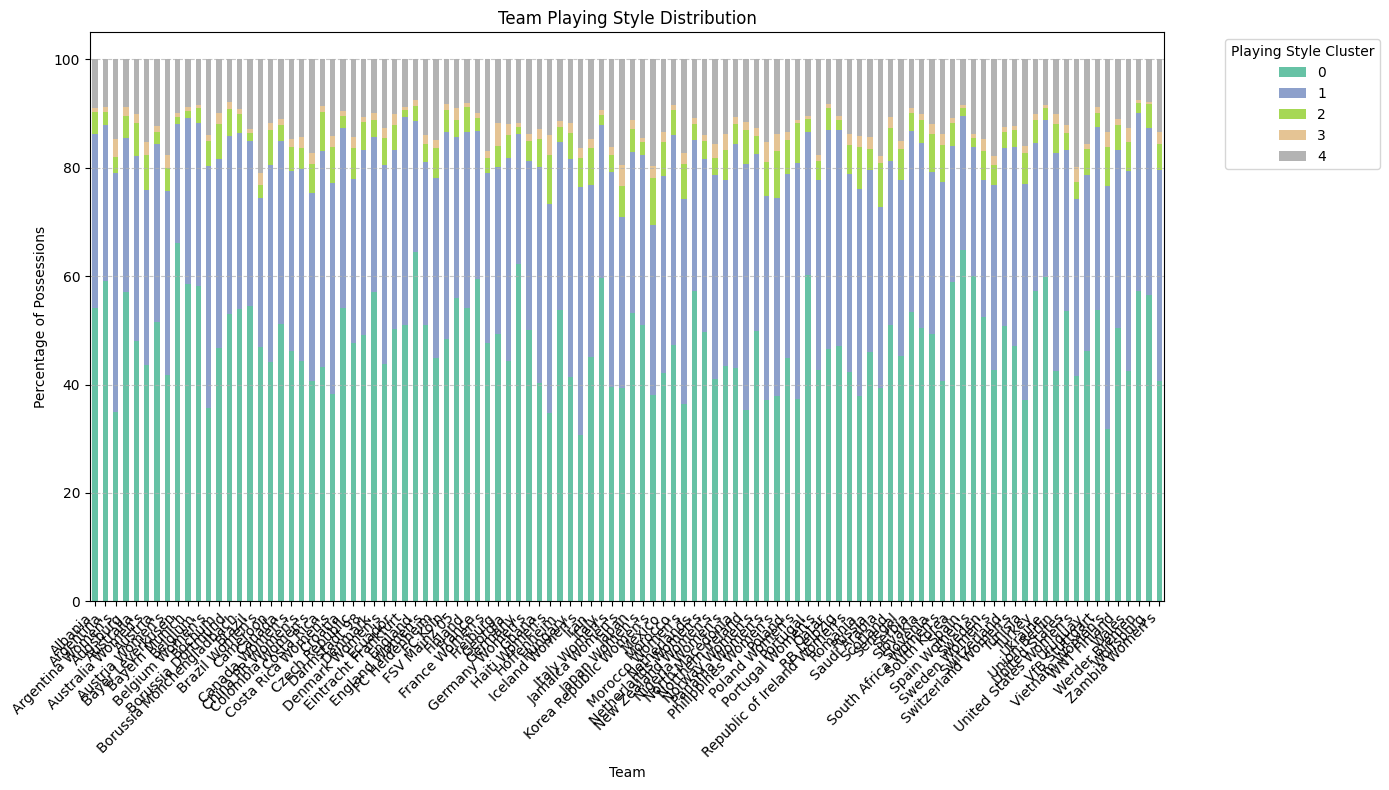

In [35]:
import matplotlib.pyplot as plt

# 3️⃣ Stacked Bar Plot for Team Playing Styles
plt.figure(figsize=(12, 8))
team_playing_styles_percentage.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set2')

plt.title('Team Playing Style Distribution')
plt.xlabel('Team')
plt.ylabel('Percentage of Possessions')
plt.legend(title='Playing Style Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


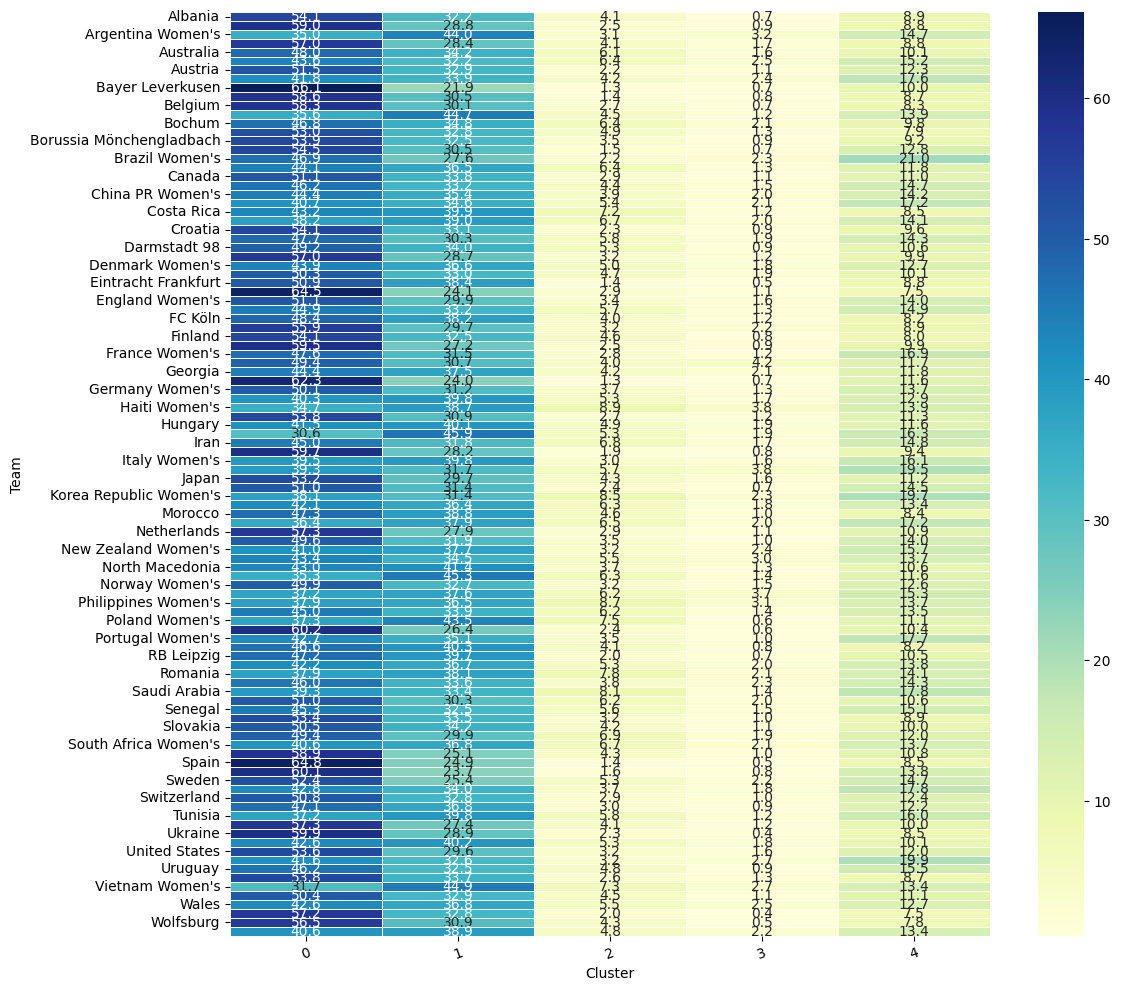

In [36]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(team_playing_styles_percentage, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5)

plt.ylabel('Team')
plt.tight_layout()

plt.xticks(rotation=20)

plt.show()


In [37]:
# 1️⃣ Mapping Cluster Numbers to Style Names
cluster_to_style = {
    0: 'High long ball from defense',
    1: 'Build-up against high press',
    2: 'Set pieces or crosses close to goal',
    3: 'Regular attack transition',
    4: 'Long possession during build-up'
}

# Apply the mapping
team_playing_styles_percentage.rename(columns=cluster_to_style, inplace=True)


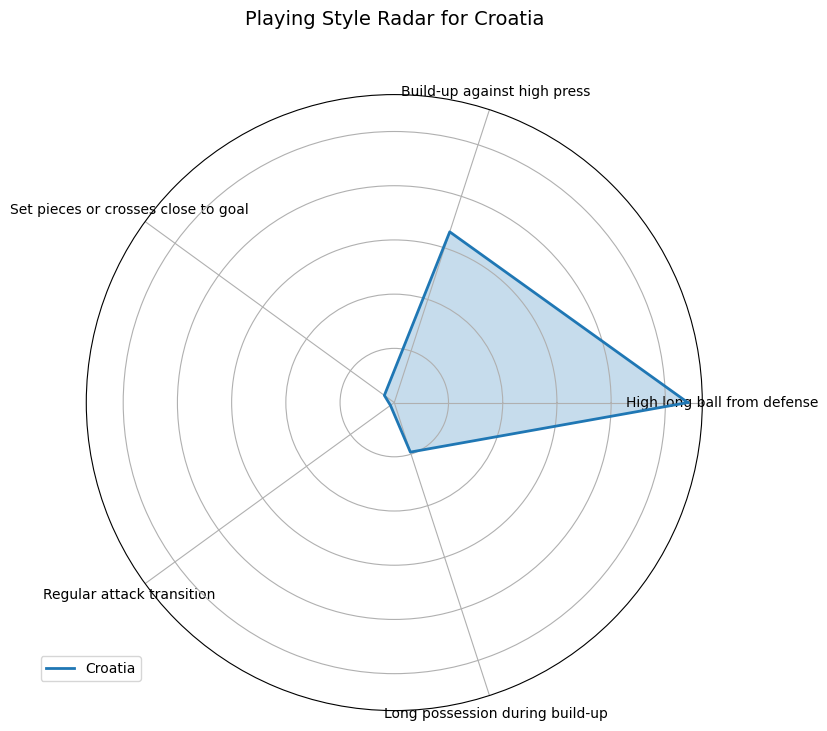

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# 2️⃣ Radar Plot Function
def plot_team_playing_style_radar(team_name, data):
    styles = data.columns.tolist()
    values = data.loc[team_name].values.tolist()

    # Close the radar plot
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(styles), endpoint=False).tolist()
    angles += angles[:1]

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=team_name)
    ax.fill(angles, values, alpha=0.25)

    # Setting labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(styles, fontsize=10)
    ax.set_yticklabels([])  # Remove radial ticks for clarity

    plt.title(f'Playing Style Radar for {team_name}', size=14, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Example: Plotting for a specific team
plot_team_playing_style_radar('Croatia', team_playing_styles_percentage)


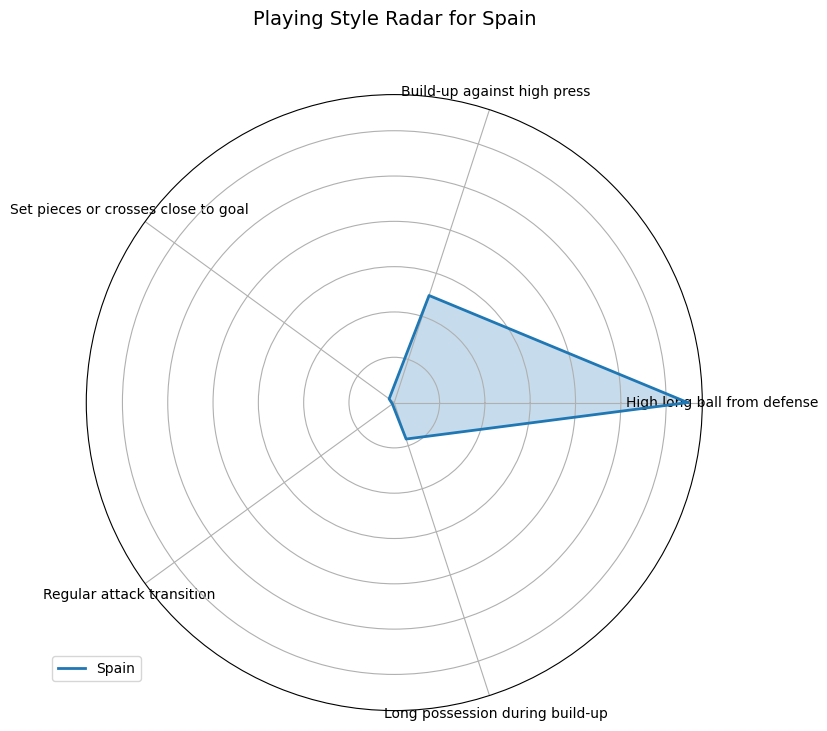

In [39]:
plot_team_playing_style_radar('Spain', team_playing_styles_percentage)

In [40]:
possession_features

,match_id,possession,avg_pass_length,avg_pass_angle,pass_success_rate,longest_forward_pass,total_xg,start_x,start_y,end_x,...,avg_opponent_count,avg_teammate_count,total_packing,wide_focus,attacking_start,on_ball_actions,set_piece,possession_dynamics,defensive_aggression,Cluster
0,3788741,2,43.357202,-0.916925,1.000000,34.5,0.0000,60.0,40.0,70.4,...,0.875000,0.250000,8,1.125000,0.000000,4,True,3.123519,0.5,1
1,3788741,3,27.267907,0.593214,0.857143,51.9,0.0000,43.1,0.1,96.9,...,0.272727,0.136364,7,0.909091,0.090909,13,True,3.586010,1.0,1
2,3788741,4,8.823832,0.897825,1.000000,5.5,0.0000,91.1,0.1,94.5,...,1.500000,2.000000,0,2.000000,0.750000,2,True,1.466672,0.5,3
3,3788741,5,8.833655,0.666568,1.000000,4.8,0.0000,83.0,0.1,91.6,...,3.666667,1.333333,2,2.000000,0.857143,3,True,2.906414,0.5,4
4,3788741,6,9.121619,0.624870,0.750000,13.1,0.0000,30.1,69.3,53.3,...,2.588235,2.470588,8,2.000000,0.117647,8,False,26.700035,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57931,4020846,228,0.000000,0.000000,0.000000,0.0,0.7835,108.1,40.1,108.1,...,0.000000,0.000000,0,0.000000,0.500000,0,False,5.591341,0.0,4
57932,4020846,229,0.000000,0.000000,0.000000,0.0,0.7835,107.8,40.1,107.8,...,0.000000,0.000000,0,0.000000,0.500000,0,False,6.990895,0.0,4
57933,4020846,230,0.000000,0.000000,0.000000,0.0,0.7835,107.9,40.1,107.9,...,0.000000,0.000000,0,0.000000,0.500000,0,False,6.477580,0.0,4
57934,4020846,231,0.000000,0.000000,0.000000,0.0,0.7835,107.9,40.1,107.9,...,0.000000,0.000000,0,0.000000,0.500000,0,False,5.952592,0.0,4


In [41]:
from requests import Session
from sqlalchemy import delete
from sql_schemas import Possessions


def init_possessions(db: Session, df, tableClass = Possessions):
    db.execute(delete(tableClass))
    db.commit()
    new_rows = [
        tableClass(
            match_id=p['match_id'], possession=p['possession'], 
            playing_style=cluster_to_style.get(p['playing_style']),
            passes=p['Pass'],
            carry=p['Carry'],
            dribble=p['Dribble'],
            shot=p['Shot'],
            duel=p['Duel'],
            pressure=p['Pressure'],
            block=p['Block'],
            ball_recovery=p['Ball Recovery'],
            interception=p['Interception'],
            clearance=p['Clearance'],
            avg_pass_length=p['avg_pass_length'],
            pass_success_rate=p['pass_success_rate'],
            possession_team_name=p['possession_team_name']
        )
        for p in df.to_dict(orient="records")
    ]
    db.bulk_save_objects(new_rows)
    db.commit()

In [49]:
db.rollback()

In [50]:
possession_features_original['Cluster'] = possession_features['Cluster']
possession_features_original.to_csv('test.csv')



In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you already have X and cluster labels
X = pd.read_csv('test.csv')



In [52]:
df = possession_features_original
df['playing_style'] = df['Cluster']
possession_team = event_df.groupby(['match_id', 'possession'])['possession_team_name'].max().reset_index()
possession_team
df = df.merge(possession_team[['match_id', 'possession', 'possession_team_name']], on=['match_id', 'possession'], how='left')
df
#df_final = df.rename(columns={"Pass": "passes"})
#df_final

init_possessions(db,df)

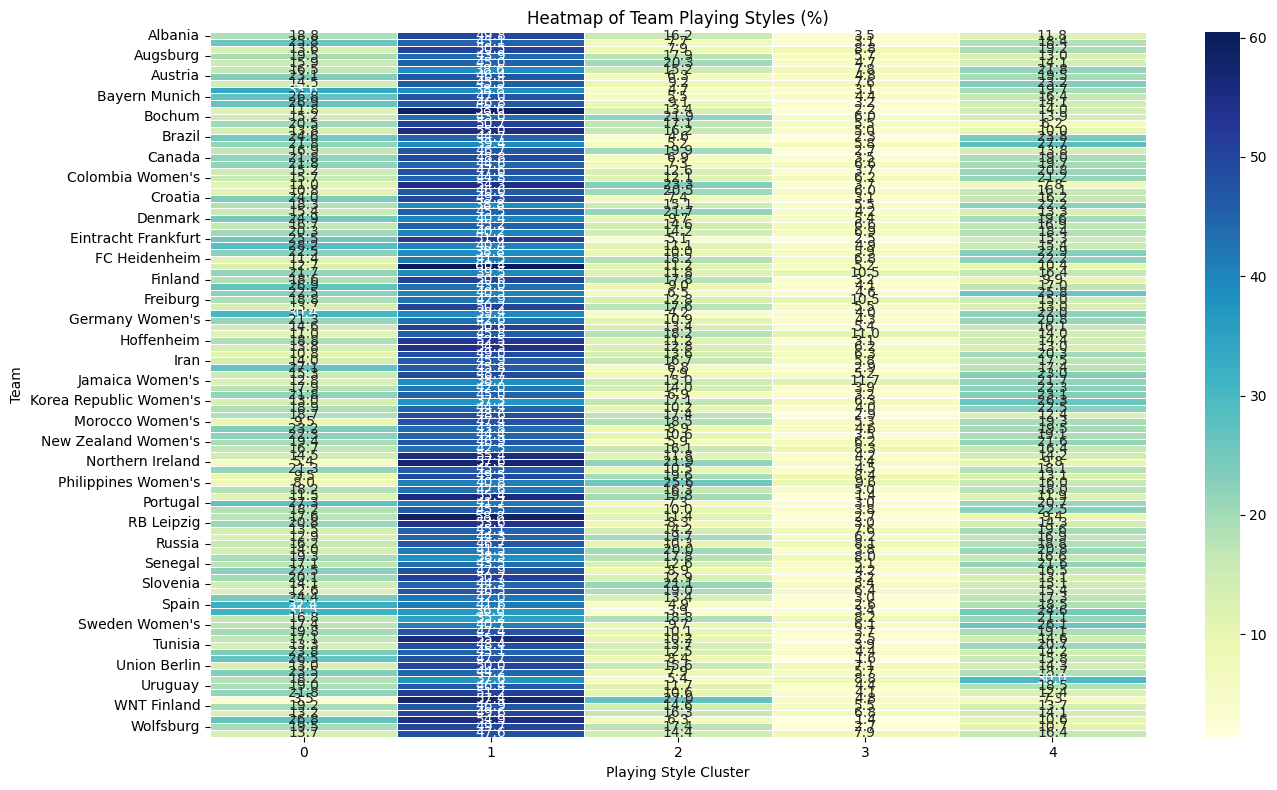

In [53]:

team_possessions = df.groupby(['possession_team_name', 'Cluster']).size().unstack(fill_value=0)


# Normalize to get percentages
team_possessions_percentage = team_possessions.div(team_possessions.sum(axis=1), axis=0) * 100
plt.figure(figsize=(14, 8))
sns.heatmap(team_possessions_percentage, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5)

plt.title('Heatmap of Team Playing Styles (%)')
plt.xlabel('Playing Style Cluster')
plt.ylabel('Team')
plt.tight_layout()

plt.show()


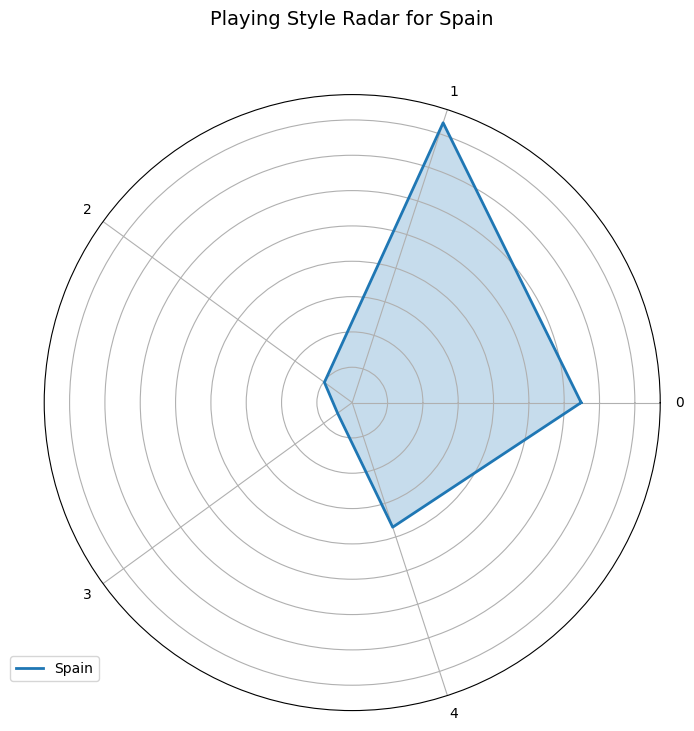

In [54]:
plot_team_playing_style_radar('Spain', team_possessions_percentage)

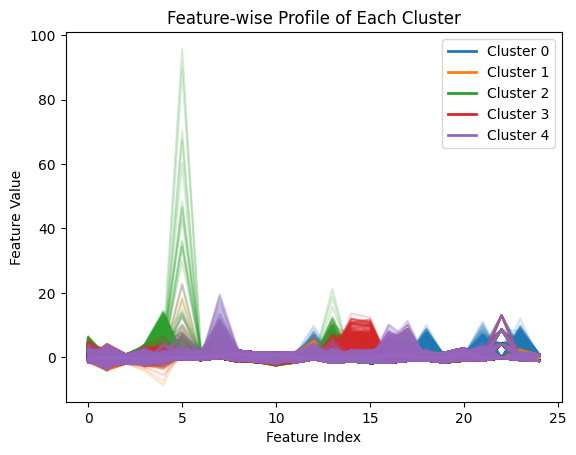

In [55]:
# Cluster
df_numeric['Cluster'] = df['Cluster']
labels = df['Cluster']

for cluster_id in np.unique(labels):
    cluster_points = scaled_features[labels == cluster_id]
    for row in cluster_points:
        plt.plot(row, alpha=0.2, color=f'C{cluster_id}')
    plt.plot(cluster_points.mean(axis=0), color=f'C{cluster_id}', label=f'Cluster {cluster_id}', linewidth=2)

plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Feature-wise Profile of Each Cluster")
plt.legend()
plt.show()

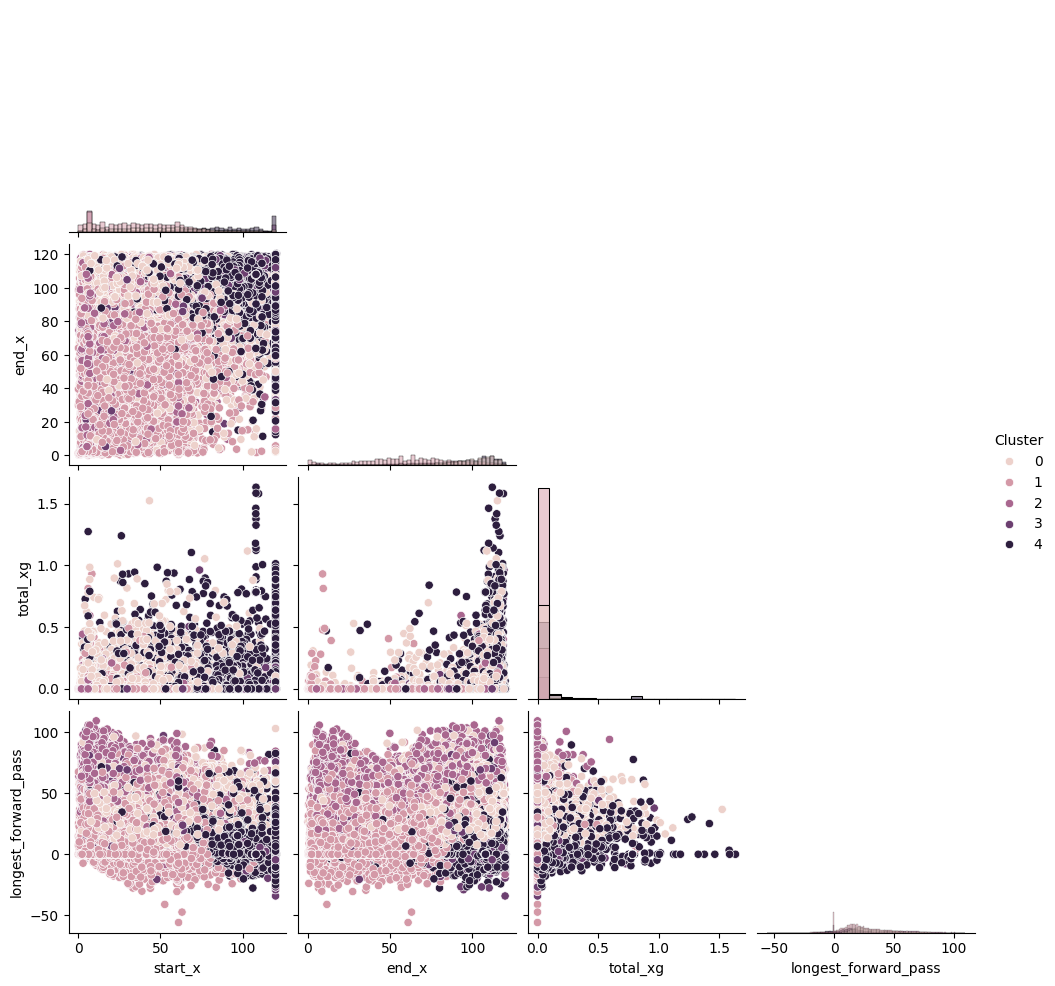

In [56]:
sns.pairplot(df_numeric.loc[:,['start_x', 'end_x', 'total_xg', 'longest_forward_pass', 'Cluster']], hue='Cluster', corner=True, diag_kind='hist')

(5, 16)


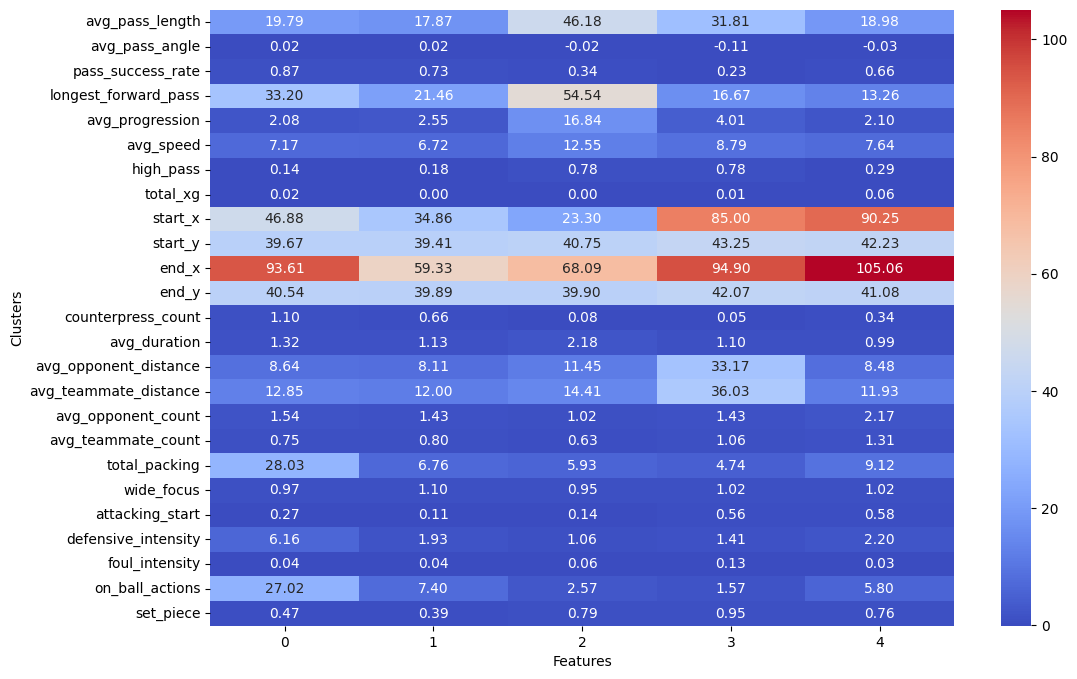

In [57]:
centers = kmeans_final.cluster_centers_
print(centers.shape) 
centers_original_space = pca_final.inverse_transform(centers)
cluster_centers_orig = scaler.inverse_transform(centers_original_space)

columns = [col for col in df_numeric.columns if col != 'Cluster']
df_centers = pd.DataFrame(cluster_centers_orig, columns=columns)

plt.figure(figsize=(12, 8))
sns.heatmap(df_centers.T, annot=True, fmt=".2f", cmap='coolwarm')
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

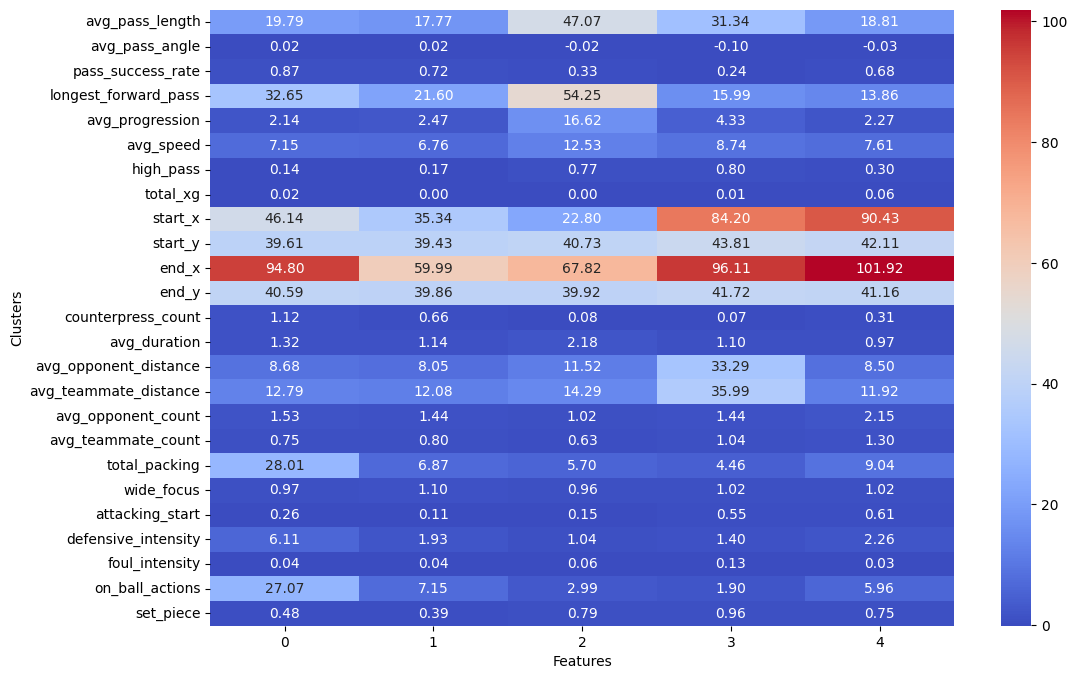

Index([0, 1, 2, 3, 4], dtype='int32', name='Cluster')

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
cluster_summary_cleaned = cluster_summary.loc[:, ~cluster_summary.columns.str.startswith('PC')]
plt.figure(figsize=(12, 8))  # adjust size as needed
sns.heatmap(cluster_summary_cleaned.T, annot=True, fmt=".2f", cmap='coolwarm')
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()
cluster_summary.T.columns

[[ 1.55621429 -1.20200594  0.90988928 ... -0.19850557 -0.53993591
   0.90793925]
 [ 0.37263293  0.78094156  0.50211699 ... -0.19850557  0.2121914
   0.90793925]
 [-0.98417382  1.18092334  0.90988928 ... -0.19850557 -0.70707531
   0.90793925]
 ...
 [-1.63328388  0.00199877 -1.94451677 ... -0.19850557 -0.87421471
  -1.10139527]
 [-1.63328388  0.00199877 -1.94451677 ... -0.19850557 -0.87421471
  -1.10139527]
 [-1.63328388  0.00199877 -1.94451677 ... -0.19850557 -0.87421471
  -1.10139527]]


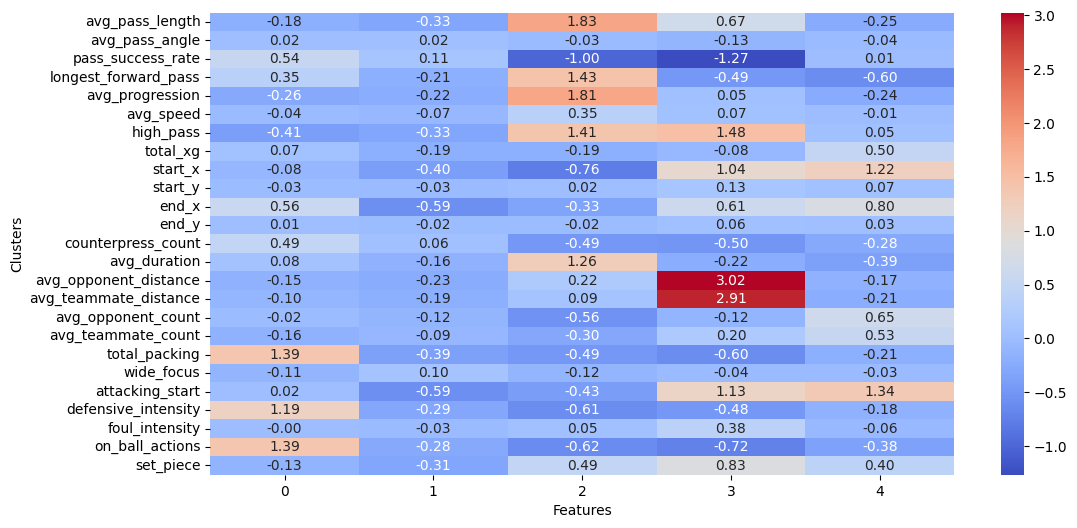

In [59]:
from pandas import DataFrame

print(scaled_features)
cluster_profiles = pd.DataFrame(scaled_features, columns=df_numeric.columns[:-1], index=df_numeric.index)
cluster_profiles['Cluster'] = df_numeric['Cluster']
cluster_summary = cluster_profiles.groupby('Cluster').mean()
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary.T, annot=True, fmt=".2f", cmap='coolwarm')
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

In [60]:
df_event_with_clusters.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id',
       ...
       'width_change', 'speed', 'distance_covered', 'angle_change',
       'nearby_opponents', 'nearby_teammates', 'teammate_distance',
       'opponent_distance', 'packing', 'Cluster'],
      dtype='object', length=103)

In [61]:
df_event_with_clusters.loc[:,['type_name','player_name','position_name','Cluster']]
df_event_with_clusters = df_event_with_clusters[df_event_with_clusters['position_name'].str.contains("Forward", na=False)]

In [62]:
a = df_event_with_clusters.groupby(['player_name', 'Cluster'])['type_name'].value_counts().reset_index()

b = df_event_with_clusters[df_event_with_clusters['type_name'] == 'Pass'].groupby(['player_name', 'Cluster'])['outcome_name'].apply(lambda g: g.isna().mean()).reset_index()
a[a['Cluster'] == 4].sort_values(by='count', ascending=False).head(20)

,player_name,Cluster,type_name,count
11711,Patrik Schick,4,Ball Receipt,114
14872,Victor Okoh Boniface,4,Ball Receipt,113
10397,Memphis Depay,4,Ball Receipt,108
576,Alessia Russo,4,Ball Receipt,106
10398,Memphis Depay,4,Pass,99
4302,Emma Stina Blackstenius,4,Ball Receipt,86
5863,Harry Kane,4,Ball Receipt,81
10399,Memphis Depay,4,Carry,78
577,Alessia Russo,4,Carry,73
4467,Esther Gonzalez Rodríguez,4,Ball Receipt,66


In [63]:
a = a.merge(b, on=['player_name', 'Cluster'], how='left')

In [64]:
c = a[a['type_name'] == 'Dribble'][a['count']> 3]
c.sort_values(by='outcome_name', ascending=False).head(20)

,player_name,Cluster,type_name,count,outcome_name
8030,Khvicha Kvaratskhelia,0,Dribble,5,0.958333
304,Akram Hassan Afif,0,Dribble,7,0.950000
6653,Jennifer Hermoso Fuentes,0,Dribble,6,0.945205
632,Alexander Isak,4,Dribble,4,0.937500
14326,Thembi Kgatlana,1,Dribble,7,0.928571
1599,Arda Güler,0,Dribble,5,0.927273
13550,Sheika Daleicha Scott Richardson,0,Dribble,4,0.923077
7738,Kasper Dolberg,4,Dribble,4,0.900000
8229,Kylian Mbappé Lottin,0,Dribble,19,0.898990
7546,Karim Benzema,1,Dribble,5,0.896552


In [65]:
df_play_pattern

,match_id,possession,avg_pass_length,avg_pass_angle,pass_success_rate,longest_forward_pass,avg_progression,avg_speed,high_pass,total_xg,...,on_ball_actions,play_pattern_From Corner,play_pattern_From Counter,play_pattern_From Free Kick,play_pattern_From Goal Kick,play_pattern_From Keeper,play_pattern_From Kick Off,play_pattern_From Throw In,play_pattern_Other,play_pattern_Regular Play
0,3788741,2,43.357202,-0.916925,1.000000,34.5,1.300000,7.570557,0.500000,0.0000,...,4,False,False,False,False,False,True,False,False,False
1,3788741,3,27.267907,0.593214,0.857143,51.9,2.577273,8.037900,0.142857,0.0000,...,13,False,False,False,False,False,False,True,False,False
2,3788741,4,8.823832,0.897825,1.000000,5.5,1.375000,3.025016,0.000000,0.0000,...,2,False,False,False,False,False,False,True,False,False
3,3788741,5,8.833655,0.666568,1.000000,4.8,1.157143,7.562098,0.000000,0.0000,...,3,False,False,False,False,False,False,True,False,False
4,3788741,6,9.121619,0.624870,0.750000,13.1,0.917647,78.932457,0.250000,0.0000,...,8,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57931,4020846,228,0.000000,0.000000,0.000000,0.0,5.950000,10.824023,0.000000,0.7835,...,0,False,False,False,False,False,False,False,True,False
57932,4020846,229,0.000000,0.000000,0.000000,0.0,5.950000,15.022686,0.000000,0.7835,...,0,False,False,False,False,False,False,False,True,False
57933,4020846,230,0.000000,0.000000,0.000000,0.0,6.050000,13.382740,0.000000,0.7835,...,0,False,False,False,False,False,False,False,True,False
57934,4020846,231,0.000000,0.000000,0.000000,0.0,6.050000,11.807775,0.000000,0.7835,...,0,False,False,False,False,False,False,False,True,False
